<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/Huberlin-logo.svg/200px-Huberlin-logo.svg.png" alt="fff" align="left" style="width: 150px;width: 150px;align:left">


# Descriptive Statistics
 
#### Thesis: Neural response generation for email conversations
#### Author: Sydney Richards
#### Required Runtime: GPU
#### Creates Figure 3 (a) and (b)






This notebook creates the two subfigures that make up Figure 3 in the thesis. The data pre processing is identical to the notebook which implment the benchamrk and neural models.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
#import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import datetime as dt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

seed = np.random.RandomState(seed=10)

### Stanford NER Tagger

Stanford NER is a Java implementation of a Named Entity Recognizer. Named Entity Recognition (NER) labels sequences of words in a text which are the names of things, such as person and company names, or gene and protein names. It comes with well-engineered feature extractors for Named Entity Recognition, and many options for defining feature extractors. Included with the download are good named entity recognizers for English and German, particularly for the 3 classes (PERSON, ORGANIZATION, LOCATION).

We use the Tagger to itdentify names and replace them with tokens, since we do not wan't our model to have to remember names just add a token at the position of the sentence were a name should appear. 

[Stanford NLP Reference](https://nlp.stanford.edu/software/CRF-NER.shtml)

In [0]:
#!pip install stanfordcorenlp

#from stanfordcorenlp import StanfordCoreNLP

In [0]:
!pip install glove_python -q


In [0]:
#import nltk

#!wget 'http://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip'
#!unzip stanford-corenlp-full-2018-10-05

#nltk.download('punkt')



In [0]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Load and Merge Datasets

Data sets are tables of e-mail activities where each activity represents a single mail either from customer to the company or vice versa. In order to link
customer enquiries and customer support responses we use the Case ID which is an unique ID given to a e-mail thread of a customer. Each customer can have multiple threads or cases and each case can have mutiple e-mails from both the customer as well as the company but the thread will usually deal with a single issue e.g. "Could ou please check if I have outstanding bills on my  acccount." 

In [0]:
### Self-Join tables over Case_ID 

## EN
activities = pd.read_csv('/content/drive/My Drive/Master Thesis/act_in_out_API.csv') 
data = pd.merge(activities.loc[activities['ACTIVITY_MODE']=='inbound',['CASE_ID','CONTENT_TEXT','CLASSIFICATIONS','Q1','Q2']],
                      activities.loc[activities['ACTIVITY_MODE']=='outbound',['CASE_ID','CONTENT_TEXT','CLASSIFICATIONS','Q1','Q2']],
                      how='inner',left_on='CASE_ID',right_on = 'CASE_ID')
data = data.loc[(data['CONTENT_TEXT_x'].isnull()==False)&(data['CONTENT_TEXT_y'].isnull()==False),:]
data = data.reset_index(drop=True)
data = data.rename({'CONTENT_TEXT_x':'Incoming','CONTENT_TEXT_y':'Outgoing'},axis=1)

In [0]:
def clean_classification(x):
  try:
    x = re.sub(r"[^a-zA-Z&; ]+", "",x).replace('deleted','').replace('cargo','<company>').strip(' ')
  except:
    x = x

  if x=='RevalidationRecheck of DL':
    x = 'Revalidation & Recheck of DL'
  elif x=='RefuellingCharging':
    x = 'Refuelling & Charging'

  return x

In [0]:
#data = pd.merge(act,msurvey,
#                      how='inner',left_on='ACTIVITY_ID',right_on = 'activityId')

In [0]:
data['CLASSIFICATIONS'] = [clean_classification(x) for x in data['CLASSIFICATIONS_x']]

In [0]:
data.shape

(149492, 10)

In [0]:
def print_overview(dataset):
  # Identify number of missing cases if only a small amount drop
  print('Data set has %s records' % "{:,.0f}".format(dataset.shape[0]))
  print('%s of records have missings' % "{0:.2f}%".format((1-(dataset.dropna().shape[0])/dataset.shape[0]) * 100))
  print(dataset.isnull().sum())

  # Show some discriptive statistics on dataset
  print('{:^40}'.format('Column Name'),'','{:10}'.format('Unique Values'),'{:^50}'.format('Examples'))
  for x in list(dataset.columns.values):
    print('{:^40}'.format(x),'','{:10d}'.format(len(dataset[x].unique())),'{:^50}'.format(str(dataset[x].unique()[:3])[:35]))


In [0]:
print_overview(data)

Data set has 149,492 records
100.00% of records have missings
CASE_ID                   0
Incoming                  0
CLASSIFICATIONS_x        15
Q1_x                 149492
Q2_x                 149492
Outgoing                  0
CLASSIFICATIONS_y     14079
Q1_y                 149492
Q2_y                 149492
CLASSIFICATIONS          15
dtype: int64
              Column Name                 Unique Values                      Examples                     
                CASE_ID                       120265               [116483 116582 116279]              
                Incoming                      125628        ['Description of issue: hi there --        
           CLASSIFICATIONS_x                    1824        ['DO NOT USE - Cleaning[**********]        
                  Q1_x                             1                       [nan]                       
                  Q2_x                             1                       [nan]                       
                Ou

In [0]:
#print_overview(dataDE)

Split E-Mail message body into individual sequences in order to clean the content from unneccessary text especially response history, headers and footers.


###### List of split symbols to extract message

|Incoming|Outgoing|
|-----|--------|
|\r\n\r\nSent|\n\n\xa0\n|
|\n\nOn|-|
|\n\n\n|-|
|\r\n\r\n\r\n|-|
|\r\nOn|-|

In [0]:
data['Outgoing'] = data['Outgoing'].str.replace('Thank you for contacting car2go!','')
#dataDE['Outgoing'] = dataDE['Outgoing'].str.replace('vielen Dank für deine E-Mail','') 
#dataDE['Outgoing'] = dataDE['Outgoing'].str.replace('vielen Dank für deine Rückmeldung','')

In [0]:
def find_split(x):
    # x: Incoming E-Mail Message
    # split_ops: list of for which string should be split
    # Idea split point should be anywhere after 5% or before 90% of the text l
    split_ops = ['\r\n\r\nSent','\r\nOn','\r\n\r\n\r\n','\r\nFrom:']
    for op in split_ops:
        if (x.find(op)>=len(x) * 0.05)&(x.find(op)<=len(x) * 0.9):
            return x[:x.find(op)]
    
    return x

In [0]:
FOOTER = ['T 1 877\xa0488 4224\nmemberservicesNA@car2go.com\nwww.car2go.com\ncar2go NA, LLC\n1717 West 6th Street, Suite #425\nAustin, Texas 78703\nCAR2GO – PROUD TO SHARE\nDisclaimer:\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.\n\n\n'
,'T 1 877 488 4224\nmemberservicesNA@car2go.com\nwww.car2go.com\n\nCAR2GO – PROUD TO SHARE\n\nDisclaimer:\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.\n\n',
         '\nT 1 855 454 1002\nmemberservicesCAN@car2go.com\nwww.car2go.com\n\ncar2go Canada Ltd.\n321 Water St, Suite #330\nVancouver, BC V6B 1B8\n\nCAR2GO – PROUD TO SHARE\n\nDisclaimer:\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.',
         '\nT 1 855 454 1002\nmemberservicesCAN@car2go.com\nwww.car2go.com\n\ncar2go Canada Ltd.\n1717\xa0West 6th St #425\nAustin, Texas 78703\n\nCAR2GO – PROUD TO SHARE\n\nDisclaimer:\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.\n',
         "\n\n\n\nIf you have any additional questions or concerns, please don't hesitate to let me know."
          ,"\nWas my solution helpful? We'd love to hear your feedback! Share your experience with us by taking part in our\xa0survey.\n",
         "\n\n\n\n\nIf you have any additional questions or concerns, please don't hesitate to contact us.",
         "Kundenservice\n\n\xa0\n\nCAR2GO – PROUD TO SHARE\n\n\xa0\n\ncar2go Deutschland GmbH\n\nAnschrift/postal address: car2go Deutschland GmbH | HPC HB20 | 10875 Berlin | Deutschland\nRegistergericht/Court of Registry: Amtsgericht Stuttgart\nHRB-Nr./Commercial Register No.: 737715\nGeschäftsführer/Board of Directors: Olivier Reppert, Stefan Glebke\n\nDisclaimer:\nDiese Mail kann vertrauliche Informationen enthalten. Wenn Sie nicht Adressat sind, sind Sie nicht zur Verwendung der in dieser Mail enthaltenen Informationen befugt. Bitte benachrichtigen Sie uns sofort über den irrtümlichen Empfang.\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.",
         "\nWas my solution helpful? We'd love to hear your feedback! Share your experience with us\xa0by taking\xa0part in our SURVEY.\n\nT 1 855 454 1002\nmemberservicesCAN@car2go.com\nwww.car2go.com\n\ncar2go Canada Ltd.\n1717\xa0West 6th St #425\nAustin, Texas 78703\n\nCAR2GO – PROUD TO SHARE\n\nDisclaimer:\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.",
         "Was my solution helpful? We'd love to hear your feedback! Share your experience with us\xa0by taking\xa0part in our SURVEY.",
         '\nT 1 855 454 1002\n\nmemberservicesCAN@car2go.com\n\nwww.car2go.com\n\ncar2go Canada Ltd.\n\n321 Water St, Suite #330\n\nVancouver, BC V6B 1B8\n\nCAR2GO – PROUD TO SHARE\n\nDisclaimer:\n\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.']

nlp = StanfordCoreNLP('/content/stanford-corenlp-full-2018-10-05')

sentence = 'Guangdong University of Foreign Studies is located in Guangzhou.'
print('Tokenize:', nlp.word_tokenize(sentence))
print('Part of Speech:', nlp.pos_tag(sentence))

!pip install fastText

!wget 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/amazon_review_full.bin'

import fasttext

model = fasttext.load_model('amazon_review_full.bin')

In [0]:
def split_out(x):
    # x: Outgoing E-Mail Message
    # Outgoing Messages always contain a similar content 
    x  = x[:x.find('--Ursprüngliche Nachricht--')]
    x = x[x.find(',')+1:]
    for f in FOOTER:
        x = x.replace(f,'')
    
    
    return '.'.join(x.split('\n\n\xa0\n')[0].split('.')[:2])

In [0]:
def name_tokenizer(x):
  for token in nlp.ner(x):
    if token[1] == 'PERSON':
      x = x.replace(token[0],'<name>')
  
  return x

In [0]:
def cash_tokenizer(x):
    #x text
    if x.find('$') > 0:
        return x.replace(x[x.find('$'):x.find('$') + x[x.find('$'):].find(' ')],'<amt>')
    elif x.find('€') > 0:
        return x.replace(x[x.find('€'):x.find('€') + x[x.find('€'):].find(' ')],'<amt>')
    return x

In [0]:
def prep_outging(x):
    x = split_out(x)
    x = cash_tokenizer(x)
    #x = name_tokenizer(x)
    
    return x

In [0]:
incomings = []
outgoings = []
#data = data.sample(50000,random_state=seed).reset_index(drop=True)
for row_no, row in data.iterrows():
    if row_no in range(0,data.shape[0],10000):
        print('...%s lines converted out of %s' % ("{:,}".format(row_no),"{:,}".format(data.shape[0])))
         
    incomings.append(find_split(row['Incoming']))
    outgoings.append(prep_outging(row['Outgoing']))


...0 lines converted out of 149,492
...10,000 lines converted out of 149,492
...20,000 lines converted out of 149,492
...30,000 lines converted out of 149,492
...40,000 lines converted out of 149,492
...50,000 lines converted out of 149,492
...60,000 lines converted out of 149,492
...70,000 lines converted out of 149,492
...80,000 lines converted out of 149,492
...90,000 lines converted out of 149,492
...100,000 lines converted out of 149,492
...110,000 lines converted out of 149,492
...120,000 lines converted out of 149,492
...130,000 lines converted out of 149,492
...140,000 lines converted out of 149,492


In [0]:
data['enquiry'] = incomings
data['reply'] = outgoings

In [0]:
### ISSSUE: To many <amt> signs after lost 5000 data points 
data = data.loc[data['reply'].str.count('<amt>')<5,:]

In [0]:
data = data.loc[(data['enquiry'].str.len()>=50)&(data['reply'].str.len()>=50),:]
data = data.reset_index(drop=True)
data.shape

(112410, 12)

In [0]:
class pd_frame_to_tf_tensor_pipe():
  def __init__(self,inputs,targets,Max_Length = 50,test_size=0.2):
    self._inputs = inputs
    self._targets = targets
    self._Max_Length = Max_Length
    self._test_size = test_size
  def _preprocess_sentence(self,w,is_input=False):
      #w = unicode_to_ascii(w.lower().strip())

      # creating a space between a word and the punctuation following it
      # eg: "he is a boy." => "he is a boy ."
      # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
      w = w.lower().strip()
      w = re.sub(r"([?.!,¿])", r" \1 ", w)
      w = re.sub(r'[" "]+', " ", w)
      w = w.replace('\n', ' ').replace('\r', ' ').replace('\xa0',' ')
      if is_input == True:
      # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,0-9]+", " ", w)
      w = w.replace('car2go','<company>')
      w = w.replace('Share Now','<company>')

      w = w.rstrip().strip()

      # adding a start and an end token to the sentence
      # so that the model know when to start and stop predicting.
      w = '<start> ' + w + ' <end>'
      return w

  def _tokenize(self,corpus):
      tokenizer = tf.keras.preprocessing.text.Tokenizer(
          filters='')
      tokenizer.fit_on_texts(corpus)

      tensor = tokenizer.texts_to_sequences(corpus)
      #tensor = [len(tokenizer.word_index)] + tensor + [len(tokenizer.word_index + 1)]
      #tensor = tf.convert_to_tensor(tensor)
      tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                            padding='post',
                                                            maxlen=self._Max_Length)

      return tensor,tokenizer
  
  def get_tensors(self):
      enquiries = [self._preprocess_sentence(x,True) for x in self._inputs]
      replies = [self._preprocess_sentence(x) for x in self._targets]

      input_tensor, input_tokenizer = self._tokenize(enquiries)
      target_tensor, target_tokenizer = self._tokenize(replies)
      
      # Calculate max_length of the target tensors
      self.max_length_targ, self.max_length_inp = max([len(x) for x in target_tensor]),max([len(x) for x in input_tensor])

      input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(input_tensor, target_tensor, test_size=0.2)

      input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor_train, target_tensor_train, test_size=0.2) 

      self.len_inp_train = len(input_tensor_train)
      
      train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(len(input_tensor_train))
      
      val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(len(input_tensor_val))
      
      test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test)).shuffle(len(input_tensor_test))

      return train_dataset, test_dataset,val_dataset, input_tokenizer, target_tokenizer


In [0]:
pipeline = pd_frame_to_tf_tensor_pipe(inputs=data['enquiry'].to_list()
                                      ,targets = data['reply'].to_list())

In [0]:
def recode_sentiment(x):
  if x<3:
    return 'negative'
  elif x==3:
    return 'neutral'
  else:
    return 'positiv'

In [0]:
data['Length_In'] = [len(x) for x in data['enquiry'].str.split(' ')]

In [0]:
msurvey = pd.read_csv('/content/drive/My Drive/Master Thesis/eSAT.csv') 

msurvey = msurvey.rename(columns={'Rate your overall experience with member services':'Q1',
                          'Was your issue fixed?':'Q2'})

msurvey = pd.merge(msurvey,activities,how='inner',left_on='activityId',right_on='ACTIVITY_ID')
msurvey['CLASSIFICATIONS'] = [clean_classification(x) for x in msurvey['CLASSIFICATIONS']]

In [0]:
f = {'Length_In': 'mean','CLASSIFICATIONS':'count'}

pivot = data.groupby(data['CLASSIFICATIONS'])

pivot = pivot.agg(f)

In [0]:

f = {'Q1': 'mean'}

test_pv = msurvey.groupby(msurvey['CLASSIFICATIONS'])

test_pv = test_pv.agg(f)

In [0]:
pivot = pd.merge(pivot, test_pv,how='inner',left_index=True, right_index=True)

In [0]:
pivot = pivot.rename(columns={'CLASSIFICATIONS':'Class'})

In [0]:
pivot = pivot.sort_values(by='Class',axis=0)

In [0]:
graph_data = pivot.loc[pivot.index[-15:],:]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

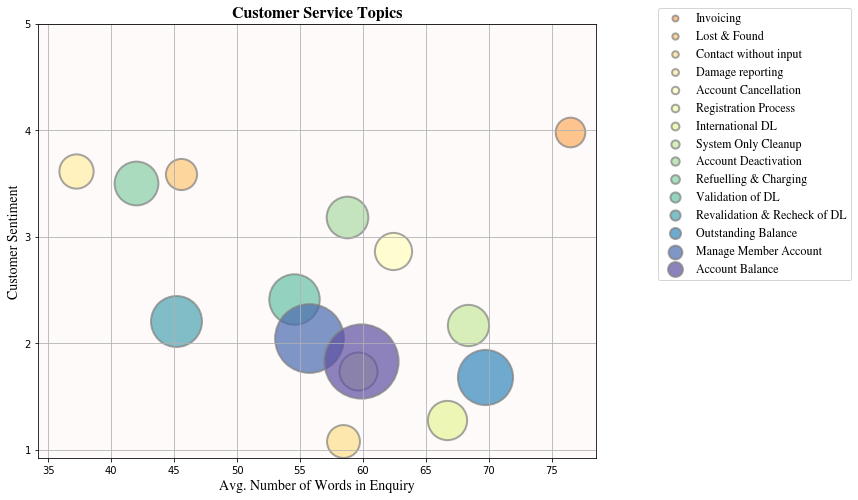

In [0]:
labelfont = {'fontsize':12, 'weight': 'normal','family':'STIXGeneral'}
axisfont = {'fontsize':14, 'weight': 'normal','family':'STIXGeneral'}
titlefont = {'fontsize':16, 'weight': 'bold','family':'STIXGeneral'}
# create data
#graph_data.index.name ='Class'
graph_data = graph_data.sort_values(by='Class')

graph_data['Color'] = np.linspace(0.3,1,len(graph_data.index))

fig, ax = plt.subplots(figsize=(10,8))

for ticker,row in graph_data.iterrows():
  ax.scatter(row['Length_In'], row['Q1'], label=ticker,s=row['Class']/2.5
             ,c=plt.cm.get_cmap('Spectral')(row['Color'])[:3], alpha=0.7, edgecolors="grey", linewidth=2)

ax.set_yticks(np.linspace(1,5,5))
ax.set_facecolor("snow")
ax.yaxis.grid()
ax.xaxis.grid()
ax.legend(markerscale=0.2,bbox_to_anchor=(1.1, 1.05),prop={'family':'STIXGeneral','size':12})
plt.xlabel("Avg. Number of Words in Enquiry",fontdict=axisfont)
plt.ylabel("Customer Sentiment",fontdict=axisfont)
plt.title("Customer Service Topics",fontdict=titlefont)
#plt.legend(loc='top right',)
plt.savefig('/content/drive/My Drive/Master Thesis/descriptiveA.png', format='png', dpi=150, bbox_inches='tight')
plt.show()




In [0]:
train_dataset, test_dataset,val_dataset, input_tokenizer, target_tokenizer = pipeline.get_tensors()
BATCH_SIZE = 64
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)


In [0]:
input_sequences = []
for batch,(inp,out) in enumerate(train_dataset):
  for row in inp.numpy():
    seq = [input_tokenizer.index_word[x] for x in row if x not in [0,input_tokenizer.word_index['<start>'],input_tokenizer.word_index['<end>']]]
    seq = re.sub(r'[^a-zA-Z?!]+', ' ',' '.join(seq)).split(' ')
    #seq = [name_tokenizer(x) for x in seq if x != '']
    input_sequences.append(seq)

In [0]:
def gen_embed_matrix(word_index,d_index,d):
    # word index from tokenizer
    # d_index trained word embedding
    # size of embedding_vecort
    # glove
    #Returns: Embedding Matrix for NN-Training
    num_words = len(word_index) + 2 # 
    embedding_matrix = np.zeros((num_words,d)) #replace n zeros with embeddings

    for word, i in word_index.items():
        if i > num_words:
            continue
        try:
          embedding_vector = d_index[word]
        except:
          try:
            embedding_vector = d_index.word_vectors[d_index.dictionary[word]]
          except:
            continue
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros
          embedding_matrix[i] = embedding_vector
        
    return embedding_matrix


In [0]:
from gensim.models import Word2Vec
# length of the vecoter representations of words
EMBEDDING_DIM = 256

#using gensim package
w2vmodel_sg = Word2Vec(sentences = input_sequences,iter=10,
                       sg=1, size = EMBEDDING_DIM,negative=5, window = 15, workers =4,min_count=1)

embeddings_matrix = gen_embed_matrix(input_tokenizer.word_index,w2vmodel_sg.wv,EMBEDDING_DIM)


In [0]:
from glove import Corpus, Glove

corpus = Corpus()

corpus.fit(input_sequences,window= 10)

glove = Glove(no_components=EMBEDDING_DIM,learning_rate=0.05)

glove.fit(corpus.matrix,epochs =10,no_threads = 4,verbose = True)

glove.add_dictionary(corpus.dictionary)

embeddings_matrixGlove = gen_embed_matrix(input_tokenizer.word_index,glove,EMBEDDING_DIM)

Performing 10 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

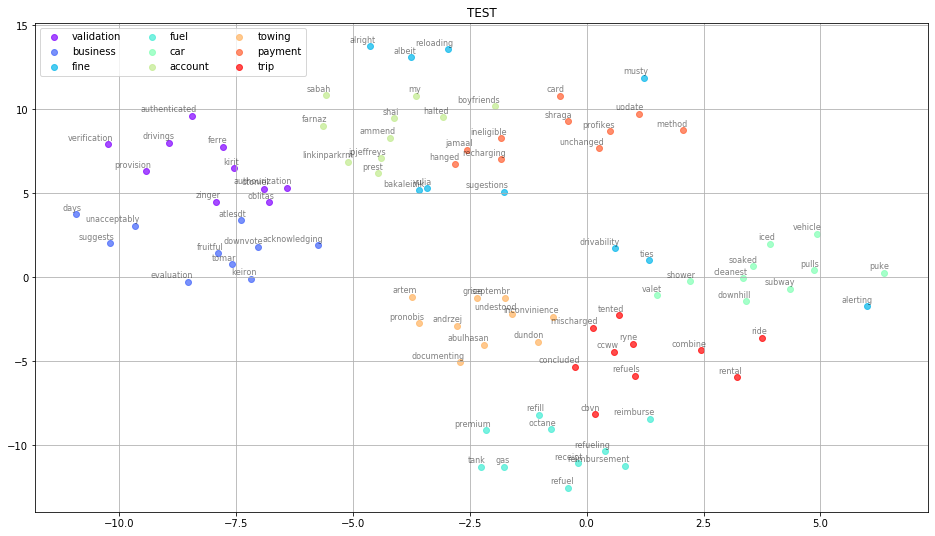

In [0]:
keys=['validation','business','fine','fuel','car','account','towing','payment','trip']

from sklearn.manifold import TSNE
import matplotlib.cm as cm

#def tsne_plot_similar_words(model,keys,title, a, filename=None):
model = w2vmodel_sg.wv
title = 'TEST'
a = 0.7

word_clusters = []
embedding_clusters = []
for word in keys:
    embeddings = []
    words = []
    
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model.get_vector(similar_word))

    embedding_clusters.append(embeddings)
    word_clusters.append(words)
  

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

plt.figure(figsize=(16, 9))
colors = cm.rainbow(np.linspace(0, 1, len(keys)))
for label, embeddings, words, color in zip(keys, embeddings_en_2d, word_clusters, colors):
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    plt.scatter(x, y, c=color, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                      textcoords='offset points', ha='right', va='bottom', size=8)
plt.legend(loc='upper left', ncol=3)
plt.title(title)
plt.grid(True)

plt.show()


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

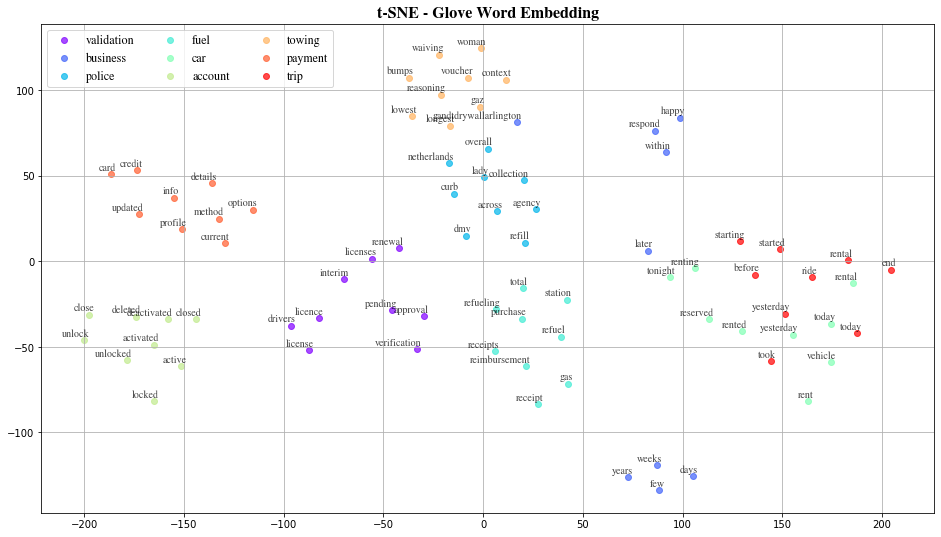

In [0]:
keys=['validation','business','police','fuel','car','account','towing','payment','trip']

#def tsne_plot_similar_words(model,keys,title, a, filename=None):
model = glove
title = 't-SNE - Glove Word Embedding'
a = 0.7

word_clusters = []
embedding_clusters = []
for word in keys:
    embeddings = []
    words = []
    
    for similar_word, _ in model.most_similar(word, 10):
        words.append(similar_word)
        embeddings.append(model.word_vectors[model.dictionary[similar_word]])

    embedding_clusters.append(embeddings)
    word_clusters.append(words)
  

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

plt.figure(figsize=(16, 9))
colors = cm.rainbow(np.linspace(0, 1, len(keys)))
for label, embeddings, words, color in zip(keys, embeddings_en_2d, word_clusters, colors):
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    plt.scatter(x, y, c=color, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.75, xy=(x[i], y[i]), xytext=(5, 2),
                      textcoords='offset points', ha='right', va='bottom', size=10,family='STIXGeneral')
plt.legend(loc='upper left', ncol=3,prop={'family':'STIXGeneral','size':12})
plt.title(title,fontdict=titlefont)
plt.grid(True)
plt.savefig('/content/drive/My Drive/Master Thesis/word_embed.png', format='png', dpi=150, bbox_inches='tight')
plt.show()
